# Submanifold Closure

# Exclusion


## Setup

In [3]:
%load_ext autoreload
import jax.numpy as jnp
from jaxtyping import Array
import matplotlib.pyplot as plt
import dynamiqs as dq
import strawberryfields as sf
import os
from jaxpulse.controllers import ControlVector, SinusoidalControl, ConstantControl, FrequencyControl, GaussianControl
from jaxpulse.optimizers import ClosedQuantumSystem, OpenQuantumSystem, OptimalController
from jaxpulse.utils import heaviside, rhodot_H
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='.90'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Drift

In [4]:
alpha = .1
beta = .2
delta = .5+.4j
gamma = .1
epsilon = 1.5 + 2j
def c(v):
    return jnp.conj(v)
H_0 = jnp.array(
    [
        [1.0,       alpha,      beta,       0.0,        0.0],
        [c(alpha),  2,          delta,      0.0,        0.0],
        [c(beta),   c(delta),   3,          gamma,      0.0],
        [0.0,       0.0,        c(gamma),   4,          epsilon],
        [0.0,       0.0,        0.0,        c(epsilon), 5]
    ]
)

### Controls

In [5]:
H_1 = jnp.array(
    [
        [0.0,  0.0,  0.0,  0.0,  0.0],
        [0.0,  0.0,  1.0,  0.0,  0.0],
        [0.0,  1.0,  0.0,  0.0,  0.0],
        [0.0,  0.0,  0.0,  0.0,  0.0],
        [0.0,  0.0,  0.0,  0.0,  0.0]
    ]
)
H_2 = jnp.array(
    [
        [0.0,  1.0,  0.0,  0.0,  0.0],
        [1.0,  0.0,  0.0,  0.0,  0.0],
        [0.0,  0.0,  0.0,  0.0,  0.0],
        [0.0,  0.0,  0.0,  0.0,  0.0],
        [0.0,  0.0,  0.0,  0.0,  0.0]
    ]
)
H_3 = jnp.array(
    [
        [0.0,  0.0,  0.0,  0.0,  0.0],
        [0.0,  0.0,  0.0,  0.0,  0.0],
        [0.0,  0.0,  0.0,  1.0,  0.0],
        [0.0,  0.0,  1.0,  0.0,  0.0],
        [0.0,  0.0,  0.0,  0.0,  0.0]
    ]
)
H_M = [H_1, H_2, H_3]
ppc = [3,3,3] # pulse per control
u_M = ControlVector(
    [
        GaussianControl(
            amp=1.0*jnp.ones((ppc[0],)),
            mean=jnp.linspace(3,9,ppc[0]),
            sigma=jnp.ones((ppc[0],))
        ),
        GaussianControl(
            amp=1.0*jnp.ones((ppc[1],)),
            mean=jnp.linspace(2,10,ppc[1]),
            sigma=1.0*jnp.ones((ppc[1],))
        ),
        GaussianControl(
            amp=1.0*jnp.ones((ppc[2],)),
            mean=jnp.linspace(2,12,ppc[2]),
            sigma=1.0*jnp.ones((ppc[2],))
        )
    ]
)

In [6]:
closure_sys = ClosedQuantumSystem(
    H_0=H_0,
    H_M=H_M
)
psi0 = dq.fock(5, 0)
duration=15

## State Exclusion
go to 2, avoid 3,4

In [7]:
# project into 3rd
proj = dq.fock_dm(5,2)
def y_final(y: Array) -> float:
    return 1000*(1 - dq.expect(proj, y))

# don't go above 3
exclude_upper = dq.fock_dm(5,3) #+ dq.fock_dm(5,4)
def y_statewise(y: Array, u: Array, t: float) -> float:
    return dq.expect(exclude_upper, y) 

In [8]:
controller = OptimalController(
    system=closure_sys,
    controls=u_M,
    y0=psi0,
    duration=duration,
    y_final=y_final,
    y_statewise=y_statewise
)
exp_ops = [dq.number(5),proj]
exp_names = [r"$\langle n \rangle$", r"$\langle 2 \rangle$"]

### Pre-Train

/home/cjblake/miniconda3/envs/jiang/lib/python3.12/site-packages/equinox/_jit.py:51: UserWarning: Complex dtype support is work in progress, please read https://github.com/patrick-kidger/diffrax/pull/197 and proceed carefully.
/tmp/ipykernel_80611/3636940499.py:6: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown


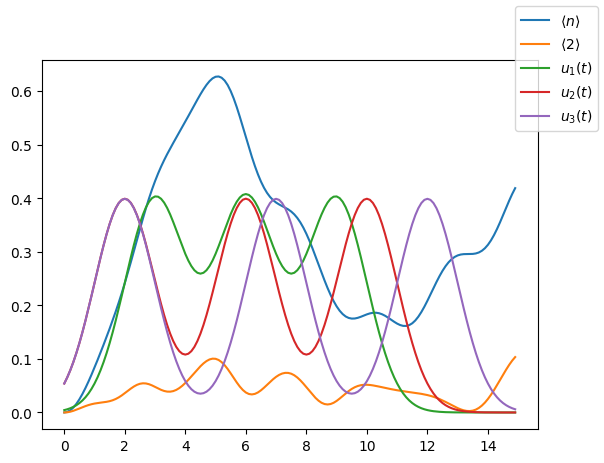

In [9]:
fig_pre, ax_pre = plt.subplots()
controller.plot(ax_pre,
                exp_ops=exp_ops,
                exp_names=exp_names)
fig_pre.legend()
fig_pre.show()

### Train

In [10]:
opt_controller = controller.optimize(
    N_steps=60,
    learning_rate=.1,
    verbosity=1)

/home/cjblake/miniconda3/envs/jiang/lib/python3.12/site-packages/equinox/_jit.py:51: UserWarning: Complex dtype support is work in progress, please read https://github.com/patrick-kidger/diffrax/pull/197 and proceed carefully.


Step: 0 Loss: 898.7310180664062
Step: 1 Loss: 742.378662109375
Step: 2 Loss: 560.052978515625
Step: 3 Loss: 370.15802001953125
Step: 4 Loss: 240.86300659179688
Step: 5 Loss: 146.10989379882812
Step: 6 Loss: 56.86347961425781
Step: 7 Loss: 61.900169372558594
Step: 8 Loss: 105.47737884521484
Step: 9 Loss: 63.951908111572266
Step: 10 Loss: 14.279641151428223
Step: 11 Loss: 9.876124382019043
Step: 12 Loss: 10.12311840057373
Step: 13 Loss: 9.53012752532959
Step: 14 Loss: 9.766767501831055
Step: 15 Loss: 25.370162963867188
Step: 16 Loss: 34.50824737548828
Step: 17 Loss: 17.19295883178711
Step: 18 Loss: 8.223649978637695
Step: 19 Loss: 6.111362934112549
Step: 20 Loss: 5.727139472961426
Step: 21 Loss: 5.138238906860352
Step: 22 Loss: 4.689647197723389
Step: 23 Loss: 4.390147686004639
Step: 24 Loss: 4.179327011108398
Step: 25 Loss: 4.075471878051758
Step: 26 Loss: 4.0391387939453125
Step: 27 Loss: 3.991410255432129
Step: 28 Loss: 3.928506851196289
Step: 29 Loss: 3.854444980621338
Step: 30 Loss:

/home/cjblake/miniconda3/envs/jiang/lib/python3.12/site-packages/equinox/_jit.py:51: UserWarning: Complex dtype support is work in progress, please read https://github.com/patrick-kidger/diffrax/pull/197 and proceed carefully.
/tmp/ipykernel_80611/2321787608.py:7: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown


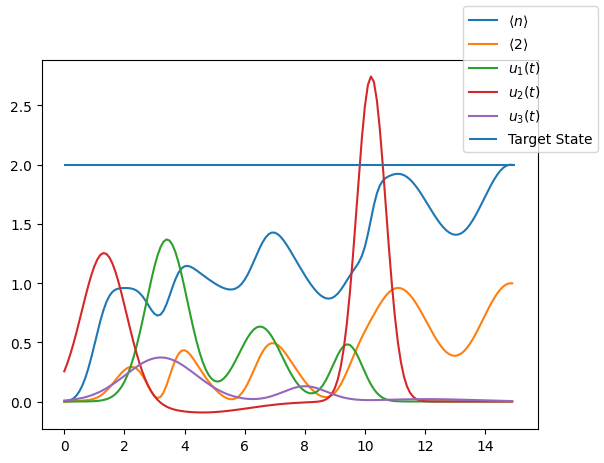

In [11]:
fig_post, ax_post = plt.subplots()
opt_controller.plot(ax_post,
                exp_ops=exp_ops,
                exp_names=exp_names)
ax_post.hlines(y=[2.0],xmin=0,xmax=duration,label="Target State")
fig_post.legend()
fig_post.show()

# Manifolds

In [23]:
closure_sys_rho = OpenQuantumSystem(
    H_0=H_0,
    H_M=H_M,
    U_K=[],
    C_K=[]
)

## Submanfold Stabilization (on $\rho$)
Go to 3, stay in 2,3

In [24]:
# project into 3rd
proj3 = dq.fock_dm(5,2)
def hit3(y: Array) -> float:
    return 1000*(1 - dq.expect(proj3, y))

# don't leave 2,3
hold23 = dq.fock_dm(5,1) + dq.fock_dm(5,2)
def stay23(y: Array, u: Array, t: float) -> float:
    return heaviside(t-5)*(1 - dq.expect(hold23, y))
rho0 = dq.todm(psi0)

In [25]:
manifold_controller = OptimalController(
    system=closure_sys_rho,
    controls=u_M,
    y0=rho0,
    duration=duration,
    y_final=hit3,
    y_statewise=stay23
)
m_exp_ops = [dq.number(5),proj3, hold23]
m_exp_names = [r"$\langle n \rangle$", r"$\langle 2 \rangle$", r"$\langle 2, 3 \rangle$"]

### Pre-Train

/home/cjblake/miniconda3/envs/jiang/lib/python3.12/site-packages/equinox/_jit.py:51: UserWarning: Complex dtype support is work in progress, please read https://github.com/patrick-kidger/diffrax/pull/197 and proceed carefully.
/tmp/ipykernel_80611/1240978354.py:6: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown


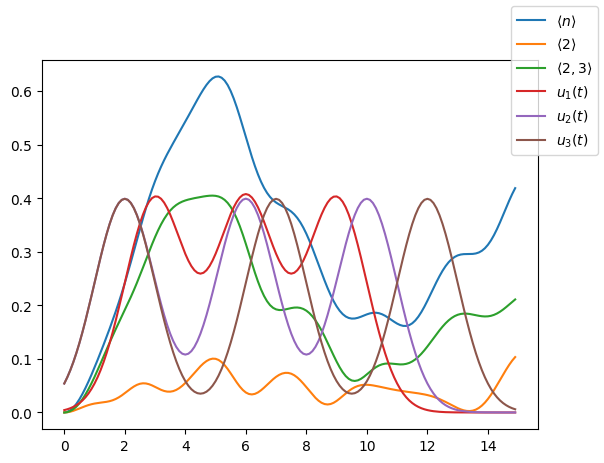

In [26]:
fig_pre, ax_pre = plt.subplots()
manifold_controller.plot(ax_pre,
                exp_ops=m_exp_ops,
                exp_names=m_exp_names)
fig_pre.legend()
fig_pre.show()

### Train

In [27]:
opt_manifold_controller = manifold_controller.optimize(
    N_steps=200,
    learning_rate=.1,
    verbosity=1
)

/home/cjblake/miniconda3/envs/jiang/lib/python3.12/site-packages/equinox/_jit.py:51: UserWarning: Complex dtype support is work in progress, please read https://github.com/patrick-kidger/diffrax/pull/197 and proceed carefully.


Step: 0 Loss: 978.4732055664062
Step: 1 Loss: 773.9901123046875
Step: 2 Loss: 567.1663818359375
Step: 3 Loss: 386.4234924316406
Step: 4 Loss: 250.30609130859375
Step: 5 Loss: 172.616455078125
Step: 6 Loss: 64.42318725585938
Step: 7 Loss: 155.53134155273438
Step: 8 Loss: 82.86366271972656
Step: 9 Loss: 40.08283996582031
Step: 10 Loss: 32.182037353515625
Step: 11 Loss: 28.351024627685547
Step: 12 Loss: 23.94856834411621
Step: 13 Loss: 20.66111946105957
Step: 14 Loss: 19.3351993560791
Step: 15 Loss: 19.245616912841797
Step: 16 Loss: 21.970081329345703
Step: 17 Loss: 64.10875701904297
Step: 18 Loss: 48.661163330078125
Step: 19 Loss: 36.22735595703125
Step: 20 Loss: 23.773120880126953
Step: 21 Loss: 17.101083755493164
Step: 22 Loss: 17.172576904296875
Step: 23 Loss: 17.927085876464844
Step: 24 Loss: 17.154571533203125
Step: 25 Loss: 16.060611724853516
Step: 26 Loss: 15.447517395019531
Step: 27 Loss: 15.187629699707031
Step: 28 Loss: 14.971305847167969
Step: 29 Loss: 14.704145431518555
Step:

/home/cjblake/miniconda3/envs/jiang/lib/python3.12/site-packages/equinox/_jit.py:51: UserWarning: Complex dtype support is work in progress, please read https://github.com/patrick-kidger/diffrax/pull/197 and proceed carefully.
/tmp/ipykernel_80611/3566152222.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown


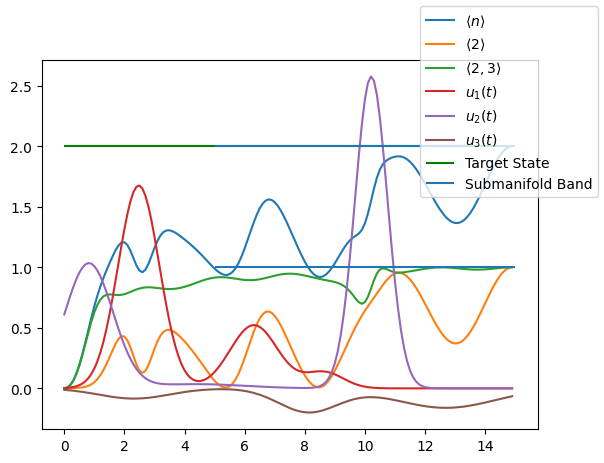

In [28]:
fig_post, ax_post = plt.subplots()
opt_manifold_controller.plot(ax_post,
                exp_ops=m_exp_ops,
                exp_names=m_exp_names)
ax_post.hlines(y=[2.0],xmin=0,xmax=duration,label="Target State",color='green')
ax_post.hlines(y=[1.0,2.0],xmin=5,xmax=duration,label="Submanifold Band")
fig_post.legend()
fig_post.show()

### Submanifold Stabilization (on $\dot{\rho}$)

In [29]:
U = jnp.array(
    [
        [0.0, 0.0],
        [1.0, 0.0],
        [0.0, 1.0],
        [0.0, 0.0],
        [0.0, 0.0]
    ], dtype=complex
)
U_dag = dq.dag(U)

# don't leave 2,3
def her0_proj(sigmadot: Array): 
    return .5*(
        dq.sigmax() * dq.trace(dq.sigmax() @ sigmadot) + 
        dq.sigmay() * dq.trace(dq.sigmay() @ sigmadot) + 
        dq.sigmaz() * dq.trace(dq.sigmaz() @ sigmadot)    
    )

def Pidot(rhodot):
    return U @ her0_proj(U_dag @ rhodot @ U) @ U_dag

hold23 = U @ U_dag
def exit23(y: Array, u: Array, t: float) -> float:
    # build rhodot
    H_tot = H_0
    for u_m, H_m in zip(u, H_M):
        H_tot = H_tot + H_m*u_m
    rhodot = rhodot_H(H_tot,y)
    # find elements exiting space
    rhodot_perp = rhodot - Pidot(rhodot)
    return heaviside(t-5)*jnp.trace(rhodot_perp @ rhodot_perp)

In [30]:
manifold_exit_controller = OptimalController(
    system=closure_sys_rho,
    controls=u_M,
    y0=rho0,
    duration=duration,
    y_final=hit3,
    y_statewise=exit23
)
m_exp_ops = [dq.number(5),proj3, hold23]
m_exp_names = [r"$\langle n \rangle$", r"$\langle 2 \rangle$", r"$\langle 2, 3 \rangle$"]

### Pre-Train

/home/cjblake/miniconda3/envs/jiang/lib/python3.12/site-packages/equinox/_jit.py:51: UserWarning: Complex dtype support is work in progress, please read https://github.com/patrick-kidger/diffrax/pull/197 and proceed carefully.
/tmp/ipykernel_80611/3823912431.py:6: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown


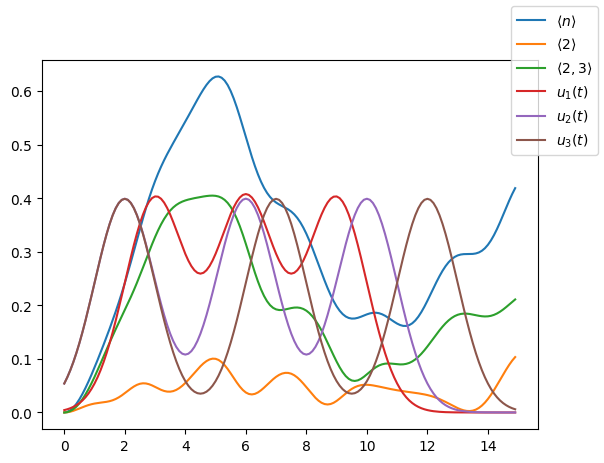

In [31]:
fig_pre, ax_pre = plt.subplots()
manifold_exit_controller.plot(ax_pre,
                exp_ops=m_exp_ops,
                exp_names=m_exp_names)
fig_pre.legend()
fig_pre.show()

In [32]:
opt_manifold_exit_controller = manifold_exit_controller.optimize(
    N_steps=200,
    learning_rate=.1,
    verbosity=1
)

/home/cjblake/miniconda3/envs/jiang/lib/python3.12/site-packages/equinox/_jit.py:51: UserWarning: Complex dtype support is work in progress, please read https://github.com/patrick-kidger/diffrax/pull/197 and proceed carefully.


Step: 0 Loss: 920.8968505859375
Step: 1 Loss: 791.1072998046875
Step: 2 Loss: 607.4758911132812
Step: 3 Loss: 428.5773620605469
Step: 4 Loss: 346.63970947265625
Step: 5 Loss: 235.5180206298828
Step: 6 Loss: 157.2023468017578
Step: 7 Loss: 116.51237487792969
Step: 8 Loss: 140.55328369140625
Step: 9 Loss: 177.5669708251953
Step: 10 Loss: 65.27461242675781
Step: 11 Loss: 60.39405059814453
Step: 12 Loss: 50.13033676147461
Step: 13 Loss: 46.79279708862305
Step: 14 Loss: 44.77958679199219
Step: 15 Loss: 42.102020263671875
Step: 16 Loss: 39.67905044555664
Step: 17 Loss: 38.33154296875
Step: 18 Loss: 37.55078887939453
Step: 19 Loss: 36.75653076171875
Step: 20 Loss: 36.06998062133789
Step: 21 Loss: 35.534156799316406
Step: 22 Loss: 35.003055572509766
Step: 23 Loss: 34.417335510253906
Step: 24 Loss: 33.79191207885742
Step: 25 Loss: 33.1489372253418
Step: 26 Loss: 32.527061462402344
Step: 27 Loss: 31.979467391967773
Step: 28 Loss: 31.523094177246094
Step: 29 Loss: 31.173179626464844
Step: 30 Loss

/home/cjblake/miniconda3/envs/jiang/lib/python3.12/site-packages/equinox/_jit.py:51: UserWarning: Complex dtype support is work in progress, please read https://github.com/patrick-kidger/diffrax/pull/197 and proceed carefully.
/tmp/ipykernel_80611/834198501.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown


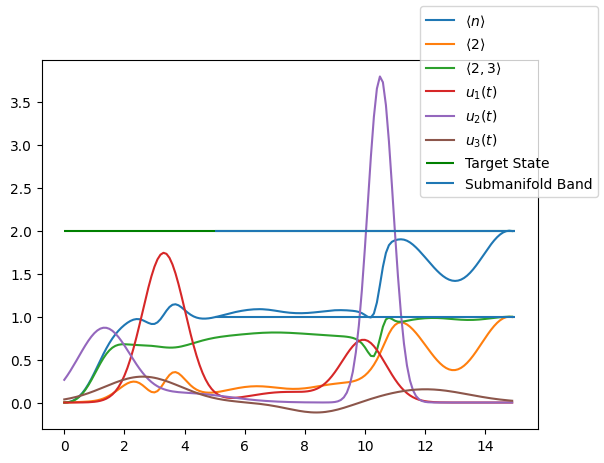

In [33]:
fig_post, ax_post = plt.subplots()
opt_manifold_exit_controller.plot(ax_post,
                exp_ops=m_exp_ops,
                exp_names=m_exp_names)
ax_post.hlines(y=[2.0],xmin=0,xmax=duration,label="Target State",color='green')
ax_post.hlines(y=[1.0,2.0],xmin=5,xmax=duration,label="Submanifold Band")
fig_post.legend()
fig_post.show()